## Web Scraping of NY Times's Bestsellers of Nonfiction for Each Sunday of Every Month in 2020 (Part 1)

<h3>Create a List for Reoccurring Days and Another List for Reocurring Dates that NY Times Publishes a New List of Nonfictional Best Sellers</h3>

In [1]:
# Returns all Sundays of a given year
from datetime import date
import calendar

month_number = []
monthly_bestsellers = []
bestsellers_every_month = []
year = 2020 # Change the year to whatever year is desired
c = calendar.TextCalendar(calendar.SUNDAY)
for m in range(1,13):
    for i in c.itermonthdays(year,m):
        if i != 0: #calendar constructs months with leading zeros (days belonging to the previous month)
            day = date(year,m,i)
            if day.weekday() == 6:
                #print("%s-%s-%s" % (year,m,i))
                bestsellers_every_month.append(i)
                monthly_bestsellers.append(calendar.month_name[m]+' '+str(i)+', '+str(year))
                month_number.append("%s" % (m))

In [2]:
bestsellers_days = []
bestsellers_months = []
for i in bestsellers_every_month:
    if i <= 9:
        bestsellers_days.append("0"+str(i))
    else:
        bestsellers_days.append(str(i))
print(bestsellers_days) 
for i in month_number:
    if int(i) <= 9:
        bestsellers_months.append("0"+str(i))
    else:
        bestsellers_months.append(str(i))
print(bestsellers_months) 

['05', '12', '19', '26', '02', '09', '16', '23', '01', '08', '15', '22', '29', '05', '12', '19', '26', '03', '10', '17', '24', '31', '07', '14', '21', '28', '05', '12', '19', '26', '02', '09', '16', '23', '30', '06', '13', '20', '27', '04', '11', '18', '25', '01', '08', '15', '22', '29', '06', '13', '20', '27']
['01', '01', '01', '01', '02', '02', '02', '02', '03', '03', '03', '03', '03', '04', '04', '04', '04', '05', '05', '05', '05', '05', '06', '06', '06', '06', '07', '07', '07', '07', '08', '08', '08', '08', '08', '09', '09', '09', '09', '10', '10', '10', '10', '11', '11', '11', '11', '11', '12', '12', '12', '12']


<h3>Create Links to Web Scrap</h3>

In [3]:
links = []
i = 0
for i in range(len(bestsellers_days)):
    links.append(f"https://www.nytimes.com/books/best-sellers/2020/{bestsellers_months[i]}/{bestsellers_days[i]}/hardcover-nonfiction/")

<h3>Web Scrap NY Times</h3>

In [4]:
from urllib.request import urlopen
import requests
import re
from datetime import datetime

bestsellers_2020 = []
bestsellers = []
bestsellers_information_2020 = []
bestsellers_data = "<p class=\"css-.{7}\">(\d+<!-- --> .*?|New this week)<\/p><h3 .*? itemProp=\"name\">(.*?)<\/h3><p .*? itemProp=\"author\">by (.*?)<\/p><p .*? itemProp=\"publisher\">(.*?)<\/p><p itemProp=\"description\" .*?>(.*?)<\/p>.*?<meta itemProp=\"position\" content=\"(.*?)\"/><meta itemProp=\"url\" content=\"(.*?)\"/><\/article>(<div class=.*? data-tooltip=\"Ranked (.*?) last week\"><\/div>|)"
bestsellers_data_2020 = "<p class=\"css-.{6}\" data-testid=\"methodology-weekly\">(.*?)<\/p>"
for i in links:
    myurl = i
    bestsellers_handle=requests.get(myurl)
    bestsellers_2020.append(bestsellers_handle.text)
whole_calendar_date = "<time class=.*? data-tooltip=\"Lists are published early online\">(.*?)<\/time>"
calendar_date = "<time class=.*? data-tooltip=\"Lists are published early online\">(.*?) (.*?), (.*?)<\/time>"
month_ranked = []
day_ranked = []
year_ranked = []
month_integer = []
calendar_date_ranked = []
numeral_calendar_date_ranked = []
for i in bestsellers_2020:
    cd = re.findall(whole_calendar_date, i)
    x = re.findall(calendar_date, i)
    m = x[0][0] # month
    day = x[0][1]
    year = x[0][2]
    month_object = datetime.strptime(m, "%B")
    ncd = str(month_object.month)+'-'+str(day)+'-'+str(year)
    month_integer.append(month_object.month)
    month_ranked.append(m)
    day_ranked.append(day)
    year_ranked.append(year)
    calendar_date_ranked.append(cd[0])
    numeral_calendar_date_ranked.append(ncd)
bestsellers_lists = "<!-- -->.*?<!-- -->.*?Rankings on weekly lists reflect sales for the week ending <!-- -->(.*?)<!-- -->"
for p, i in enumerate(bestsellers_2020):
    x = re.findall(bestsellers_data, i)
    y = []
    for j in x:
        j = list(j)
        l = j[0].split('<!-- -->')
        j[0] = l[0]
        j = [numeral_calendar_date_ranked[p], calendar_date_ranked[p], month_integer[p], month_ranked[p], day_ranked[p], year_ranked[p], *j] # include date bestsellers were ranked
        check = "<div class=\".*?\" data-tooltip=\"Ranked .*? last week\"></div>"
        if re.match(check, j[-2]):
            j.pop(-2)
        elif re.match("",j[-2]):
            j.pop(-1)
            j[-1] = None
        r = re.findall(bestsellers_data_2020, i)
        r = re.findall(bestsellers_lists, r[0])
        j.append(r[0])
        y.append(j)
    bestsellers.append(y)

<h3>Export Data to CSV</h3>

In [5]:
import time
#Write stock data to file
timestr = time.strftime("%Y%m%d-%H%M%S"+".csv")#name the file with time and date
try:
    filehandle=open(timestr,'w')
    for i in bestsellers:
        for z in i:
            for y in z:      
                filehandle.write("".join([str(y)]))
                if y is z[-1]:
                    filehandle.write("\n")
                elif y is not z[-1]:
                    filehandle.write("\t") 
    filehandle.close()    
except:
    print('The file cannot be created and written to an accessible location. Ensure that the location to write a file is accessible.')

In [6]:
import pandas as pd

<h3>Import Data from CSV and Read into Pandas as a Dataframe</h3>

In [6]:
# Change the directory path from where the CSV exists
nonfiction_bestsellers_2020 = pd.read_csv("/home/jason/20201230-203547.csv", 
                  sep='\t', index_col=False, 
                  names=["date_data", "published_data", "month_number", "month", "day", "year", "weeks_on_list", "title", "author", "publisher", "synopsis", "rank", "book_link", "rank_last_week", "ending_week_sales"],
                  encoding='utf-8')

<h3>Import Data from List and Read into Pandas as a Dataframe</h3>

In [7]:
nonfiction_bestsellers = []
for i in bestsellers:
    for k in i:
        k[11] = int(k[11]) # convert rank from string to integer
        nonfiction_bestsellers.append(k)
print(nonfiction_bestsellers) 

[['1-5-2020', 'January 5, 2020', 1, 'January', '5', '2020', '54', 'BECOMING', 'Michelle Obama', 'Crown', 'The former first lady describes how she balanced work, family and her husband’s political ascent.', 1, 'https://www.nytimes.com/books/best-sellers/2020/01/05/hardcover-nonfiction#QmVzdFNlbGxlckJvb2s6MTUyNDc2MzEzNi05NzgxNTI0NzYzMTM4', '3', 'December 21, 2019'], ['1-5-2020', 'January 5, 2020', 1, 'January', '5', '2020', '96', 'EDUCATED', 'Tara Westover', 'Random House', 'The daughter of survivalists, who is kept out of school, educates herself enough to leave home for university.', 2, 'https://www.nytimes.com/books/best-sellers/2020/01/05/hardcover-nonfiction#QmVzdFNlbGxlckJvb2s6MDM5OTU5MDUwMS05NzgwMzk5NTkwNTA0', '1', 'December 21, 2019'], ['1-5-2020', 'January 5, 2020', 1, 'January', '5', '2020', '10', 'ME', 'Elton John', 'Holt', 'The multi-award-winning solo artist&#x27;s first autobiography chronicles his career, relationships and private struggles.', 3, 'https://www.nytimes.com/b

<h3>Pickle The Dictionary and Store The Dictionary into A Flat File</h3>

In [8]:
# pickle the data structure for more analyses later
import pickle

filename = 'nonfiction_bestsellers_2020'
outfile = open(filename,'wb')
pickle.dump(nonfiction_bestsellers,outfile)
outfile.close()

<h3>Create The Data Frame</h3>

In [9]:
columns=["date_data", "published_data", "month_number", "month", "day", "year", "weeks_on_list", "title", "author", "publisher", "synopsis", "rank", "book_link", "rank_last_week", "ending_week_sales"]
nonfiction_bestsellers_2020 = pd.DataFrame(nonfiction_bestsellers, columns = columns)

<h3>Check Dataframe and Basic Stats</h3>

In [10]:
nonfiction_bestsellers_2020

,date_data,published_data,month_number,month,day,year,weeks_on_list,title,author,publisher,synopsis,rank,book_link,rank_last_week,ending_week_sales
0,1-5-2020,"January 5, 2020",1,January,5,2020,54,BECOMING,Michelle Obama,Crown,The former first lady describes how she balanc...,1,https://www.nytimes.com/books/best-sellers/202...,3,"December 21, 2019"
1,1-5-2020,"January 5, 2020",1,January,5,2020,96,EDUCATED,Tara Westover,Random House,"The daughter of survivalists, who is kept out ...",2,https://www.nytimes.com/books/best-sellers/202...,1,"December 21, 2019"
2,1-5-2020,"January 5, 2020",1,January,5,2020,10,ME,Elton John,Holt,The multi-award-winning solo artist&#x27;s fir...,3,https://www.nytimes.com/books/best-sellers/202...,2,"December 21, 2019"
3,1-5-2020,"January 5, 2020",1,January,5,2020,15,TALKING TO STRANGERS,Malcolm Gladwell,"Little, Brown",Famous examples of miscommunication serve as t...,4,https://www.nytimes.com/books/best-sellers/202...,5,"December 21, 2019"
4,1-5-2020,"January 5, 2020",1,January,5,2020,7,SAM HOUSTON AND THE ALAMO AVENGERS,Brian Kilmeade,Sentinel,The &quot;Fox &amp; Friends” host gives an acc...,5,https://www.nytimes.com/books/best-sellers/202...,4,"December 21, 2019"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,12-27-2020,"December 27, 2020",12,December,27,2020,3,MODERN WARRIORS,Pete Hegseth,Broadside,The Fox News host and former combat veteran in...,11,https://www.nytimes.com/books/best-sellers/202...,8,"December 12, 2020"
776,12-27-2020,"December 27, 2020",12,December,27,2020,13,KILLING CRAZY HORSE,Bill O&#x27;Reilly and Martin Dugard,Holt,The ninth book in the conservative commentator...,12,https://www.nytimes.com/books/best-sellers/202...,11,"December 12, 2020"
777,12-27-2020,"December 27, 2020",12,December,27,2020,9,HUMANS,Brandon Stanton,St. Martin&#x27;s,Photos and stories of people from over 40 coun...,13,https://www.nytimes.com/books/best-sellers/202...,12,"December 12, 2020"
778,12-27-2020,"December 27, 2020",12,December,27,2020,11,THE ANSWER IS ...,Alex Trebek,Simon &amp; Schuster,A memoir by the host of the TV game show “Jeop...,14,https://www.nytimes.com/books/best-sellers/202...,15,"December 12, 2020"


In [11]:
nonfiction_bestsellers_2020.shape

(780, 15)

In [12]:
nonfiction_bestsellers_2020.title.value_counts()

BECOMING                                                     43
UNTAMED                                                      40
EDUCATED                                                     37
HOW TO BE AN ANTIRACIST                                      30
THE SPLENDID AND THE VILE                                    28
                                                             ..
DON&#x27;T LIE TO ME AND STOP TRYING TO STEAL OUR FREEDOM     1
DO YOU FEEL LIKE I DO?                                        1
MEMORIAL DRIVE                                                1
ELEANOR                                                       1
ACCIDENTALLY WES ANDERSON                                     1
Name: title, Length: 191, dtype: int64

<h3>Find The Top Ten Nonfictional Books That Have Remained on NY Times's Bestseller Lists for 2020</h3>

In [13]:
top_ten = nonfiction_bestsellers_2020.title.value_counts()
print('Book Title                   Weeks')
print('')
print(top_ten.head(10))

Book Title                   Weeks

BECOMING                     43
UNTAMED                      40
EDUCATED                     37
HOW TO BE AN ANTIRACIST      30
THE SPLENDID AND THE VILE    28
THE MAMBA MENTALITY          22
TALKING TO STRANGERS         21
CASTE                        19
BETWEEN THE WORLD AND ME     14
KILLING CRAZY HORSE          13
Name: title, dtype: int64


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Plot The Top Ten Nonfictional Books That Have Remained on NY Times's Bestsellers Lists for 2020</h3>

Text(0, 0.5, 'Weeks')

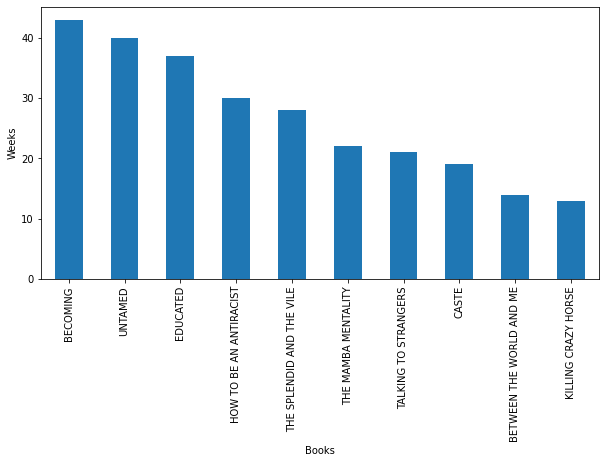

In [15]:
plt.figure(figsize=(10,5))
top_ten.head(10).plot(kind='bar');
plt.xticks(rotation=90);
plt.xlabel("Books")
plt.ylabel("Weeks")
#plt.rcParams["figure.figsize"] = (85,85)

In [16]:
new = nonfiction_bestsellers_2020.filter(['date_data','title','rank'])

In [17]:
df1 = new.loc[new['title'] == 'BECOMING']
df2 = new.loc[new['title'] == 'UNTAMED']
df3 = new.loc[new['title'] == 'EDUCATED']
df4 = new.loc[new['title'] == 'HOW TO BE AN ANTIRACIST']
df5 = new.loc[new['title'] == 'THE SPLENDID AND THE VILE']
df6 = new.loc[new['title'] == 'THE MAMBA MENTALITY']
df7 = new.loc[new['title'] == 'TALKING TO STRANGERS ']
df8 = new.loc[new['title'] == 'CASTE']
df9 = new.loc[new['title'] == 'BETWEEN THE WORLD AND ME']
df10 = new.loc[new['title'] == 'KILLING CRAZY HORSE']

In [18]:
result = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=False, sort=True)

In [19]:
result['date_data'] = pd.to_datetime(result['date_data'])
result['date_data'] = result['date_data'].dt.strftime('%m-%d-%Y')

In [21]:
result = result.sort_values(by = 'date_data')

In [22]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [23]:
result

,date_data,rank,title
0,01-05-2020,1,BECOMING
1,01-05-2020,2,EDUCATED
15,01-12-2020,1,BECOMING
16,01-12-2020,2,EDUCATED
32,01-19-2020,3,BECOMING
30,01-19-2020,1,EDUCATED
47,01-26-2020,3,BECOMING
58,01-26-2020,14,HOW TO BE AN ANTIRACIST
45,01-26-2020,1,EDUCATED
63,02-02-2020,4,BECOMING


In [24]:
import seaborn as sns
result_melted = result.melt("date_data",var_name="title",value_name="rank")

<ipython-input-24-cac4d457c2cb>:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  result_melted = result.melt("date_data",var_name="title",value_name="rank")


In [25]:
result_melted

,date_data,title,rank
0,01-05-2020,rank,1
1,01-05-2020,rank,2
2,01-12-2020,rank,1
3,01-12-2020,rank,2
4,01-19-2020,rank,3
5,01-19-2020,rank,1
6,01-26-2020,rank,3
7,01-26-2020,rank,14
8,01-26-2020,rank,1
9,02-02-2020,rank,4


<h3>Plot The Top Ten Nonfictional Books That Have Changed Ranking on NY Times's Bestsellers Lists Every Week within 2020</h3>

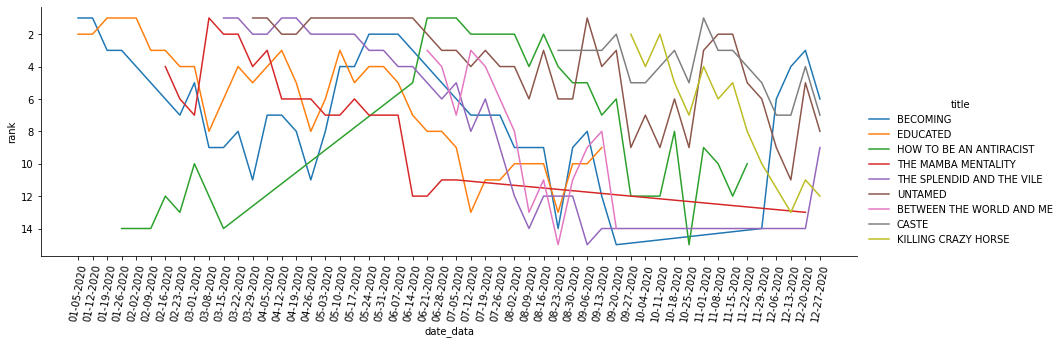

In [26]:
sns.relplot(data=result, x="date_data", y="rank", hue="title", kind="line", height=4, aspect=3)
plt.xticks(rotation=80);
plt.gca().invert_yaxis()